In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    from google.colab import drive
    drive.mount('/content/drive/')

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from collections import defaultdict
import os
import json
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from src.dataset_handling import TextClassificationDataset
from src.utils import get_activations_and_labels, get_hidden_activations
from src.sparse_autoencoders import SAE_topk

In [3]:
load_from_drive = False

model_url = "EleutherAI/pythia-14m"
model_name = model_url.split('/')[-1]
hookpoint_name = 'gpt_neox.layers.$.mlp.act'
layer = 3

model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_url)

num_hookpoints = model.config.num_hidden_layers
hookpoint = hookpoint_name.replace('$', str(layer))
input_size = model.config.intermediate_size

In [4]:
expansion_factor = 4
meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': 8,
    "pre_encoder_bias": True,
    "same_W": False
}

k = meta_data['k']

sae = SAE_topk(meta_data=meta_data).to(device)

if load_from_drive:
    sae.load_state_dict(torch.load(f'../drive/MyDrive/models/{hookpoint}.pt', weights_only=True, map_location=device))
else:
    sae.load_state_dict(torch.load(f'models/sparse_autoencoders/pythia-14m/topk{k}/{hookpoint}.pt', weights_only=True, map_location=torch.device('cpu')))

In [5]:
def get_biling_acts(dataset, model, tokenizer, stop_after = 100):

    da_acts = []
    da_preacts = []
    da_tokens = []
    en_acts = []
    en_preacts = []
    en_tokens = []

    for i in range(stop_after):

        sent, label = dataset[i]

        tokenized = [
            tokenizer(input_, return_tensors='pt').to(device)
            for input_ in [sent]
        ]

        transformer_acts = get_hidden_activations(model, hookpoint, tokenized)

        sae_preacts = sae.get_preacts(transformer_acts)
        sae_acts = sae.get_activations(transformer_acts)

        for act_indices, preacts, token in zip(sae_acts.indices, sae_preacts, tokenized[0]['input_ids'][0]):

            zeros = torch.zeros(input_size * expansion_factor)

            zeros[act_indices] = 1

            if label == 0:
                da_acts.append(zeros.detach())
                da_preacts.append(preacts.detach())
                da_tokens.append(token.item())
            else:
                en_acts.append(zeros.detach())
                en_preacts.append(preacts.detach())
                en_tokens.append(token.item())

    return (
        torch.stack(da_acts).cpu().numpy(),
        torch.stack(da_preacts).cpu().numpy(),
        da_tokens,
        torch.stack(en_acts).cpu().numpy(),
        torch.stack(en_preacts).cpu().numpy(),
        en_tokens
    )


def get_characteristic_tokens(preacts, tokens, neuron, value, less_than=False):
    if less_than:
        ids = np.array(tokens)[(preacts[:, neuron] < value)]
    else:
        ids = np.array(tokens)[(preacts[:, neuron] > value)]

    return tokenizer.convert_ids_to_tokens(ids)


def find_histogram_overlap(da_preacts, en_preacts, neuron, num_bins=30):

    min_da_preact = np.min(da_preacts[:, neuron])
    min_en_preact = np.min(en_preacts[:, neuron])
    min_preact = min(min_da_preact, min_en_preact)

    max_da_preact = np.max(da_preacts[:, neuron])
    max_en_preact = np.max(en_preacts[:, neuron])
    max_preact = max(max_da_preact, max_en_preact)

    bins = np.linspace(min_preact, max_preact, num_bins)

    da_hist = np.histogram(da_preacts[:,neuron], bins=bins)[0]
    en_hist = np.histogram(en_preacts[:,neuron], bins=bins)[0]

    da_hist = da_hist / np.sum(da_hist)
    en_hist = en_hist / np.sum(en_hist)

    overlap = np.sum(np.minimum(da_hist, en_hist))

    avg_da_preact = np.mean(da_preacts[:, neuron])
    avg_en_preact = np.mean(en_preacts[:, neuron])
    if avg_da_preact > avg_en_preact:
        return overlap, 'da'
    else:
        return overlap, 'en'



def plot_difference_by_neuron(da_preacts, en_preacts, neuron, output_file=None):

    # da_preacts_tnsr = torch.stack(da_preacts).detach().cpu()
    # en_preacts_tnsr = torch.stack(en_preacts).detach().cpu()

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_title(f'Neuron {neuron}')
    ax.hist(da_preacts[:, neuron], density=True, bins=30, alpha=0.5, color='blue',  label='Danish tokens')
    ax.hist(en_preacts[:, neuron], density=True, bins=30, alpha=0.5, color='orange', label='English tokens')
    ax.set_yticks([])
    ax.set_xlabel('pre-activations')

    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))

    fig.tight_layout()
    fig.show()

    if output_file:
        fig.savefig(output_file)


In [6]:
## TEXT PRINTING

def format_chars(text):
    formatted = (
        text.replace('Ġ', ' ').
            replace('Ã¥', 'å').
            replace('Ã¦', 'æ').
            replace('Ã¸', 'ø')
    )
    return formatted


# absolute genius stuff form chatgpt

def rgb_text(text, r, g, b, background=False):
    """Returns text formatted with 24-bit RGB color."""
    if background:
        if (r + g + b) / 3 > 128:
            return f"\033[38;2;0;0;0m\033[48;2;{r};{g};{b}m{text}\033[0m"
        else:
            return f"\033[38;2;255;255;255m\033[48;2;{r};{g};{b}m{text}\033[0m"
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"




def print_colored_preacts(tokens, preacts, neuron, tokenizer, stop_after=100):

    min_preact = np.min(preacts[:, neuron])
    max_preact = np.max(preacts[:, neuron])

    for idx, (token, preact) in enumerate(zip(tokens, preacts)):
        if idx == stop_after:
            break
        if idx % 20 == 0:
            print('')
        formatted = format_chars(tokenizer.convert_ids_to_tokens(token))
        value = preact[neuron].item()

        if value > 0:
            print(rgb_text(formatted, r=int((abs(value) / abs(max_preact)) * 255), g=0, b=0, background=True), end='')
        else:
            print(rgb_text(formatted, r=0, g=0, b=int((abs(value) / abs(min_preact)) * 255), background=True), end='')


def print_colored_acts(tokens, acts, neuron, tokenizer, stop_after=100):

    for idx, (token, act) in enumerate(zip(tokens, acts)):
        if idx == stop_after:
            break
        if idx % 20 == 0:
            print('')

        formatted = format_chars(tokenizer.convert_ids_to_tokens(token))
        value = act[neuron].item()

        if value:
            print(rgb_text(formatted, r=255, g=0, b=0, background=True), end='')
        else:
            print(formatted, end='')




In [7]:
# for identifying neurons overrepresented in one language

data_path = 'data/split/tedtalks_test.tsv'
dataset = TextClassificationDataset.from_tsv(data_path)

da_acts, da_preacts, da_tokens, en_acts, en_preacts, en_tokens = get_biling_acts(dataset, model, tokenizer, stop_after=100)


# for checking those neurons

data_path = 'data/parallel/ELRC_2923.tmx'
dataset = TextClassificationDataset.from_tmx(data_path, 'da', 'en')

da_acts2, da_preacts2, da_tokens2, en_acts2, en_preacts2, en_tokens2 = get_biling_acts(dataset, model, tokenizer, stop_after=100)

In [8]:
# getting overrepresented neurons

avg_da = sum(da_acts) / len(da_acts)
avg_en = sum(en_acts) / len(en_acts)

max_diff_neuron = np.argmax(avg_da - avg_en).item()
sorted_by_diff = sorted([(diff, idx) for idx, diff in enumerate(avg_da - avg_en)], key=lambda x: x[0], reverse=True)

overlaps = []

for i in range(input_size*expansion_factor):
    overlap, highest_lan = find_histogram_overlap(da_preacts, en_preacts, i, num_bins=30)
    if highest_lan == 'da':
        overlaps.append((overlap, i))


overlaps = sorted(overlaps, key=lambda x: x[0])

min_overlap_neuron = overlaps[0][1]

In [14]:
neurons_common_in_da_but_not_en = np.where((avg_da > 0.2) & (avg_en < 0.05))

neurons_to_plot = neurons_common_in_da_but_not_en[0]
num_neurons_to_plot = len(neurons_to_plot)

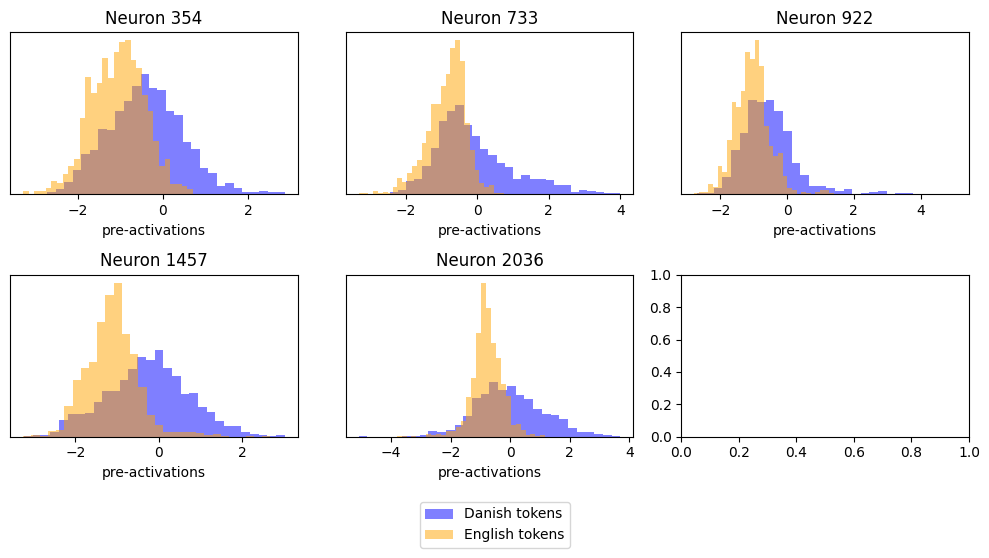

In [ ]:


fig, axs = plt.subplots(2, math.ceil(num_neurons_to_plot / 2), figsize=(10, 5))
axs = axs.flatten()

for idx, neuron in enumerate(neurons_to_plot):

    ax = axs[idx]
    ax.set_title(f'Neuron {neuron}')
    if idx == 0:
        ax.hist(da_preacts2[:, neuron], density=True, bins=30, alpha=0.5, color='blue',  label='Danish tokens')
        ax.hist(en_preacts2[:, neuron], density=True, bins=30, alpha=0.5, color='orange', label='English tokens')
    else:
        ax.hist(da_preacts2[:, neuron], density=True, bins=30, alpha=0.5, color='blue')
        ax.hist(en_preacts2[:, neuron], density=True, bins=30, alpha=0.5, color='orange')
        
    ax.set_yticks([])
    ax.set_xlabel('pre-activations')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
fig.tight_layout()

fig.savefig('multiple_neurons_preacts.pdf', bbox_inches='tight')

In [57]:
neuron_to_use = 733

C:\Users\Bruger\AppData\Local\Temp\ipykernel_1520\2144737987.py:103: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


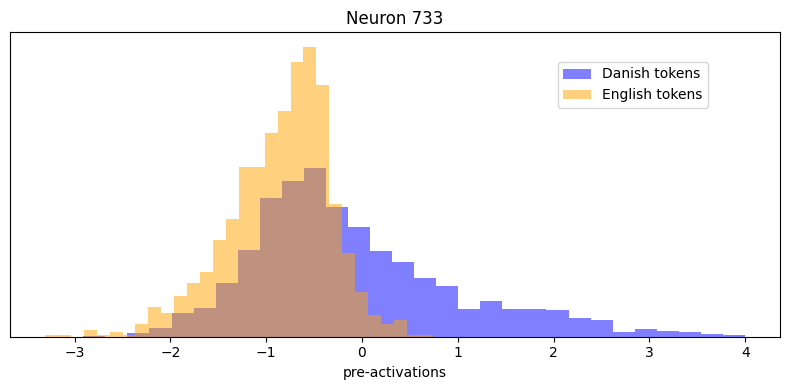

In [58]:
plot_difference_by_neuron(da_preacts2, en_preacts2, neuron_to_use, output_file='graph_overlap.pdf')

In [59]:
begin_at = 0


print_colored_acts(
    da_tokens2[begin_at:],
    da_acts2[begin_at:],
    neuron_to_use,
    tokenizer,
    stop_after=400
)
print('')
print_colored_acts(
    en_tokens2[begin_at:],
    en_acts2[begin_at:],
    neuron_to_use,
    tokenizer,
    stop_after=400
)


Corona Response Investment Initiative .Rådet skal nu formelt godkende Parlamentets holdning
.Foranstaltningerne vil stille op til 800 mio. EUR til rå
dighed for EU landene i 2020.Næste skridtHasteforanst
altninger, der skal hjælpe borgere og virksomheder med
 at tackle krisen, blev sat til afstemning på et plenarmøde
 mindre end to uger efter, at Kommissionen fremsatte sine forslag.Mid
lerne vil blive rettet mod sundhedssystemer, SMV'er,
 arbejdsmarkeder og andre sårbare dele af EU-medlemslandenes ø
konomier.Formålet med disse foranstaltninger er at kanalisere
 37 mia. EUR fra eksisterende EU-midler til de borgere,
 regioner og lande, der er hårdest ramt af Coronavirus-pandemien
 så hurtigt som muligt.Som en del af EU's fælles svar
 mod COVID-19-udbruddet vedtog medlemmerne næsten en
stemmigt tre hasteforslag på en ekstraordinær plenarforsamling tors
dag.Dette vil forhindre luftfartsselskaberne i at fly
ve med tomme fly under pandemien.Støtteberettigede tiltag under
 fonden, vil blive

In [60]:
print_colored_preacts(
    da_tokens2[begin_at:],
    da_preacts2[begin_at:],
    neuron_to_use,
    tokenizer,
    stop_after=400
)
print('')
print_colored_preacts(
    en_tokens2[begin_at:],
    en_preacts2[begin_at:],
    neuron_to_use,
    tokenizer,
    stop_after=400
)


Corona Response Investment Initiative .Rådet skal nu formelt godkende Parlamentets holdning
.Foranstaltningerne vil stille op til 800 mio. EUR til rå
dighed for EU landene i 2020.Næste skridtHasteforanst
altninger, der skal hjælpe borgere og virksomheder med
 at tackle krisen, blev sat til afstemning på et plenarmøde
 mindre end to uger efter, at Kommissionen fremsatte sine forslag.Mid
lerne vil blive rettet mod sundhedssystemer, SMV'er,
 arbejdsmarkeder og andre sårbare dele af EU-medlemslandenes ø
konomier.Formålet med disse foranstaltninger er at kanalisere
 37 mia. EUR fra eksisterende EU-midler til de borgere,
 regioner og lande, der er hårdest ramt af Coronavirus-pandemien
 så hurtigt som muligt.Som en del af EU's fælles svar
 mod COVID-19-udbruddet vedtog medlemmerne næsten en
stemmigt tre hasteforslag på en ekstraordinær plenarforsamling tors
dag.Dette vil forhindre luftfartsselskaberne i at fly
ve med tomme fly under pandemien.Støtteberettigede tiltag under
 fonden, vil blive

In [61]:
hidden_acts_outfolder = 'results/sparse_autoencoder_activations'

if not os.path.isdir(f'{hidden_acts_outfolder}'):
    os.mkdir(f'{hidden_acts_outfolder}')

if not os.path.isdir(f'{hidden_acts_outfolder}/{model_name}'):
    os.mkdir(f'{hidden_acts_outfolder}/{model_name}')

df = pd.DataFrame({'avg_da': avg_da.numpy(), 'avg_en': avg_en.numpy()})
df.to_csv(f'{hidden_acts_outfolder}/{model_name}/{hookpoint}.csv', index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'